In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/SCDC/fwd_dyn`


In [3]:
using PyPlot, PyCall
using JLD2
using Graphs
using LaTeXStrings

In [16]:
labels = Dict("EPI"=>"SCDC","EPIapprox"=>"SCDCa","MF"=>"IBMF","SIB"=>"BP","sampling"=>"MCMC")
colors =  Dict("EPI"=>"C0","MF"=>"C1","SIB"=>"C2","sampling"=>"C3","EPIapprox"=>"C4")
markers = Dict("EPI"=>"o","MF"=>"s","SIB"=>"^","sampling"=>"v","EPIapprox"=>"d")
linestyle = Dict("EPI"=>"-","MF"=>":","SIB"=>"-.","sampling"=>"--","EPIapprox"=>(0, (3, 5, 1, 5, 1, 5)));

graph_types = ["Bethe", "RRG4", "RRG15", "Prox"]
data = Dict("Bethe"=>JLD2.load("res_lambda/bethe_N-485_K-4_tmax-5_nsrc-5.jld2"),
            "RRG4"=>JLD2.load("res_lambda/RRG_N-500_K-4_nsrc-5.jld2"),
            "RRG15"=>JLD2.load("res_lambda/RRG_N-500_K-15_nsrc-5.jld2"),
            "Prox"=>JLD2.load("res_lambda/Prox_N-500_lmax-0.075_nsrc-5.jld2"))

graphs = Dict("Bethe"=>"Regular tree", "RRG4"=>"RRG, K=4", "RRG15"=>"RRG, K=15", "Prox"=>"Proximity")
tmax = Dict("Bethe"=>25, "RRG4"=>25, "RRG15"=>15, "Prox"=>15)
NVs = Dict("Bethe"=>485, "RRG4"=>500, "RRG15"=>500, "Prox"=>500)

Dict{String, Int64} with 4 entries:
  "RRG15" => 500
  "Bethe" => 485
  "Prox"  => 500
  "RRG4"  => 500

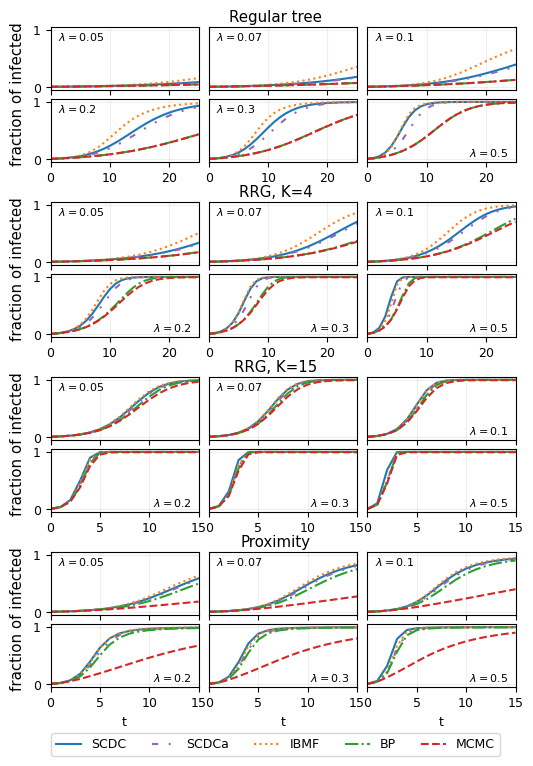

In [18]:
rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 9 #9 #18

fig = figure(figsize = (6,7)) 
subfigs = fig.subfigures(4, 1, hspace=0)  # One subfigure for each graph type

function draw_λval!(ax, i, g, λ)
    pos = Dict("Bethe"=>5, "RRG4"=>3, "RRG15"=>2, "Prox"=>3)
    if i > pos[g]
        ax.text(0.95, 0.05, L"\lambda = %$λ", transform=ax.transAxes, fontsize=8, verticalalignment="bottom", horizontalalignment="right")
    else
        ax.text(0.05, 0.95, L"\lambda = %$λ", transform=ax.transAxes, fontsize=8, verticalalignment="top", horizontalalignment="left")
    end
end


for (gix, graph) in enumerate(graph_types)
    λvec = data[graph]["lambdavec"]
    res = data[graph]["res"]
    
    subfig = subfigs[gix]
    subfig.suptitle(graphs[graph])  # Add title for the graph type
    
    axs = subfig.subplots(2, 3, sharex=true, sharey=true, gridspec_kw=Dict("hspace"=>0.15, "wspace"=>0.07))  # 2x2 grid of plots for λ values
    axs = [axs[i,j] for i in 1:2 for j in 1:3]
    
    for (ix, λ) in enumerate(λvec)
        ax = axs[ix]
        
        ax.set_xlim(0,tmax[graph])

        for meth in ["EPI", "EPIapprox", "MF", "SIB", "sampling"]
            if ix==1 && graph=="Bethe"
                ax.plot(0:tmax[graph], res[λ][meth][1:tmax[graph]+1] ./ NVs[graph], color=colors[meth], lw=1.5, linestyle=linestyle[meth], label=labels[meth])
            else
                ax.plot(0:tmax[graph], res[λ][meth][1:tmax[graph]+1] ./ NVs[graph], color=colors[meth], lw=1.5, linestyle=linestyle[meth])
            end
        end

        # Add infection probability inside the plot
        if ix ∈ 1:3
            ax.tick_params(
                axis="x",          # changes apply to the x-axis
                which="both",      # both major and minor ticks are affected
                bottom=true,      # ticks along the bottom edge are off
                top=false,         # ticks along the top edge are off
                labelbottom=false,
                ) # labels along the bottom edge are off
        end
        
        if ix ∉ [1,4]
            ax.tick_params(
                axis="y",          # changes apply to the x-axis
                which="both",      # both major and minor ticks are affected
                left=false,      # ticks along the bottom edge are off
                right=false,         # ticks along the top edge are off
                labelleft=false,
                ) # labels along the bottom edge are off
        end
        
        draw_λval!(ax, ix, graph, λ)
        ax.grid(alpha=0.2)
        
        if ix ∈ 4:6 && graph=="Prox"
            ax.set_xlabel("t")
        end
        
        subfig.supylabel("fraction of infected", x=.07, y=0.5, verticalalignment="center", horizontalalignment="center")
    end
end

# Add a legend outside all subfigures
fig.legend(
    loc="center",
    bbox_to_anchor=(0.5, -0.055),
    ncol=5
)

fig.savefig("varlambda_fwd.pdf", format="pdf", bbox_inches="tight")